# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


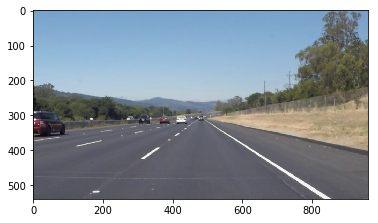

In [17]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [192]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines_solid(img, lines, color=[255, 0, 0], thickness=10):
    # Maintain slopes of left and right lane lines, to average later.
    slopes_left = []
    slopes_right = []
    # Filter slopes that have abs value less than 0.45
    slope_thres=0.45
    # Filter points which are almost alighed with axis
    dist_thres = 10
    # To average the lines, lets save the centers of the lines and average them later and extend them to the boundaries.
    center_x_left = []
    center_y_left = []
    center_x_right = []
    center_y_right = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1)/(x2 - x1)
            if abs(x2-x1) < dist_thres or abs(y2-y1) < dist_thres:
                continue
            if abs(slope) > slope_thres:
                if slope < 0:
                    center_x_left.append((x1 + x2)/2)
                    center_y_left.append((y1 + y2)/2)
                    slopes_left.append(slope)
                else:
                    center_x_right.append((x1 + x2)/2)
                    center_y_right.append((y1 + y2)/2)
                    slopes_right.append(slope)

    slopes_left_mean = np.sum(slopes_left)/len(slopes_left)
    center_x_left_mean = np.sum(center_x_left)/len(center_x_left)
    center_y_left_mean = np.sum(center_y_left)/len(center_y_left)
    
    slopes_right_mean = np.sum(slopes_right)/len(slopes_right)
    center_x_right_mean = np.sum(center_x_right)/len(center_x_right)
    center_y_right_mean = np.sum(center_y_right)/len(center_y_right)
    
    ybottom = img.shape[0]
    ytop = 330
    
    # Let's find (m, b) in x = my + b because we know ytop and ybottom, so we just need to
    # find xtop, xbottom for left and right lane.
    m_left =  1/slopes_left_mean
    b_left = center_x_left_mean - (m_left * center_y_left_mean)
    m_right = 1/slopes_right_mean
    b_right = center_x_right_mean - (m_right * center_y_right_mean)

    mean_left_line = np.poly1d([m_left, b_left])
    mean_right_line = np.poly1d([m_right, b_right])

    cv2.line(img, (int(mean_left_line(ybottom)), ybottom),  (int(mean_left_line(ytop)), ytop), color, 10)
    cv2.line(img, (int(mean_right_line(ybottom)), ybottom),  (int(mean_right_line(ytop)), ytop), color, 10)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_solid(line_img, lines, 10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [193]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [194]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def line_finder(image):
    #print('This image is: ',type(image), 'with dimensions:', image.shape)
    # Grab the x and y size and make a copy of the image
    ysize = image.shape[0]
    xsize = image.shape[1]

    # Note: always make a copy rather than simply using "="
    image_output= np.copy(image)
    # Read in and grayscale the image
    gray = cv2.cvtColor(image_output,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array(
        [[(140, ysize),(430, 330), (580, 330), (950, ysize)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 # minimum number of pixels making up a line
    max_line_gap = 12    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Draw the lines on the edge image
    image_output = weighted_img(line_image, image, α=0.9, β=10., λ=0.)
    return image_output

for filename in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + filename)
    image_output = line_finder(image)
    # plt.figure()
    # plt.imshow(image_output)
    cv2.imwrite("test_images_output/" + filename, cv2.cvtColor(image_output, cv2.COLOR_RGB2BGR))
    


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [195]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [196]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = line_finder(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [197]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



100%|█████████▉| 221/222 [00:03<00:00, 72.88it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.47 s, sys: 686 ms, total: 3.15 s
Wall time: 3.46 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [198]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [199]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:09<00:00, 68.89it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.97 s, sys: 1.89 s, total: 9.86 s
Wall time: 10.4 s


In [200]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [187]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

356 630 540 501 -0.701086956522
277 686 401 599 -0.701612903226
358 439 572 425 -0.0654205607477
368 497 584 440 -0.263888888889
528 504 603 456 -0.64
255 686 519 508 -0.674242424242
252 686 499 520 -0.672064777328
377 435 513 424 -0.0808823529412
281 685 343 641 -0.709677419355
544 500 582 473 -0.710526315789
473 361 508 375 0.4
612 455 672 427 -0.466666666667
291 517 333 506 -0.261904761905
618 421 641 400 -0.913043478261
484 538 521 513 -0.675675675676
615 421 630 407 -0.933333333333
591 469 626 444 -0.714285714286
581 441 661 427 -0.175
479 362 514 372 0.285714285714
503 519 537 497 -0.647058823529
626 380 667 434 1.31707317073
610 456 667 431 -0.438596491228
383 610 526 510 -0.699300699301
586 472 616 449 -0.766666666667
335 597 354 587 -0.526315789474
625 401 650 436 1.4
523 507 573 474 -0.66
334 597 353 587 -0.526315789474
575 473 600 459 -0.56
629 443 672 433 -0.232558139535
335 600 355 587 -0.65
440 365 478 378 0.342105263158
337 600 352 590 -0.666666666667
602 457 640 439 -0.


  0%|          | 0/251 [00:00<?, ?it/s]

356 630 540 501 -0.701086956522
277 686 401 599 -0.701612903226
358 439 572 425 -0.0654205607477
368 497 584 440 -0.263888888889
528 504 603 456 -0.64
255 686 519 508 -0.674242424242
252 686 499 520 -0.672064777328
377 435 513 424 -0.0808823529412
281 685 343 641 -0.709677419355
544 500 582 473 -0.710526315789
473 361 508 375 0.4
612 455 672 427 -0.466666666667
291 517 333 506 -0.261904761905
618 421 641 400 -0.913043478261
484 538 521 513 -0.675675675676
615 421 630 407 -0.933333333333
591 469 626 444 -0.714285714286
581 441 661 427 -0.175
479 362 514 372 0.285714285714
503 519 537 497 -0.647058823529
626 380 667 434 1.31707317073
610 456 667 431 -0.438596491228
383 610 526 510 -0.699300699301
586 472 616 449 -0.766666666667
335 597 354 587 -0.526315789474
625 401 650 436 1.4
523 507 573 474 -0.66
334 597 353 587 -0.526315789474
575 473 600 459 -0.56
629 443 672 433 -0.232558139535
335 600 355 587 -0.65
440 365 478 378 0.342105263158
337 600 352 590 -0.666666666667
602 457 640 439 -0.


  1%|          | 3/251 [00:00<00:10, 23.24it/s]

 669 427 -0.515151515152
565 484 584 473 -0.578947368421
197 679 229 661 -0.5625
258 684 277 670 -0.736842105263
187 681 226 659 -0.564102564103
579 475 651 435 -0.555555555556
589 360 604 371 0.733333333333
282 684 376 616 -0.723404255319
475 538 566 479 -0.648351648352
258 686 294 658 -0.777777777778
498 530 527 512 -0.620689655172
421 434 442 419 -0.714285714286
511 413 523 428 1.25
279 670 373 605 -0.691489361702
198 678 229 660 -0.58064516129
528 511 574 478 -0.717391304348
286 665 306 650 -0.75
437 482 475 472 -0.263157894737
590 360 603 370 0.769230769231
404 584 424 571 -0.65
492 535 514 519 -0.727272727273
-0.657867978928 0.963141025641
290 518 592 438 -0.264900662252
348 440 653 419 -0.0688524590164
418 576 486 531 -0.661764705882
521 508 614 450 -0.623655913978
351 436 496 426 -0.0689655172414
415 588 537 505 -0.680327868852
304 654 428 568 -0.693548387097


531 508 636 440 -0.647619047619
640 442 663 427 -0.652173913043
424 487 466 475 -0.285714285714
312 665 411 591 -0.747474747475
555 491 598 463 -0.651162790698
365 503 500 465 -0.281481481481
288 682 342 642 -0.740740740741
480 536 494 526 -0.714285714286
613 409 647 420 0.323529411765
257 685 308 650 -0.686274509804
618 448 674 432 -0.285714285714
276 673 317 644 -0.707317073171
515 512 552 489 -0.621621621622
321 511 384 494 -0.269841269841
416 362 453 376 0.378378378378
337 647 420 585 -0.746987951807
395 383 439 368 -0.340909090909
468 470 531 453 -0.269841269841
604 461 639 439 -0.628571428571
423 432 440 413 -1.11764705882
497 524 514 514 -0.588235294118
286 


  2%|▏         | 5/251 [00:00<00:11, 20.97it/s]

683 307 667 -0.761904761905
623 445 665 431 -0.333333333333
563 492 579 472 -1.25
412 580 442 559 -0.7
298 658 329 636 -0.709677419355
291 522 330 512 -0.25641025641
636 400 676 432 0.8
493 528 506 518 -0.769230769231
444 558 501 523 -0.614035087719
400 588 414 578 -0.714285714286
631 446 648 436 -0.588235294118
-0.720671112568 0.8
288 520 466 472 -0.269662921348
354 440 656 419 -0.0695364238411
339 629 613 451 -0.649635036496
318 660 404 599 -0.709302325581
285 525 458 478 -0.271676300578
518 426 658 416 -0.0714285714286
376 617 504 530 -0.6796875
473 469 602 437 -0.248062015504
348 440 636 420 -0.0694444444444
298 675 344 642 -0.717391304348
411 592 524 515 -0.681415929204
635 444 677 432 -0.285714285714
353 437 512 424 -0.0817610062893
517 519 606 459 -0.674157303371
285 685 316 663 -0.709677419355
529 510 590 469 -0.672131147541
315 646 369 610 -0.666666666667
370 608 601 458 -0.649350649351
289 664 337 632 -0.666666666667
624 408 665 421 0.317073170732
463 362 503 372 0.25
619 448


  3%|▎         | 7/251 [00:00<00:11, 20.53it/s]

 669 -0.7
-0.704504326189 1.10311355311
298 679 573 480 -0.723636363636
509 519 599 459 -0.666666666667
468 471 555 447 -0.275862068966
348 440 624 421 -0.0688405797101
267 683 454 557 -0.673796791444
381 620 476 551 -0.726315789474
629 447 676 433 -0.297872340426
507 425 661 415 -0.0649350649351
449 559 584 468 -0.674074074074
374 436 506 425 -0.0833333333333
403 493 501 465 -0.285714285714
288 521 413 487 -0.272
289 525 416 490 -0.275590551181
563 445 660 428 -0.175257731959
590 466 606 455 -0.6875
586 473 601 462 -0.733333333333
416 382 462 372 -0.217391304348
642 430 660 416 -0.777777777778
631 399 665 428 0.852941176471
607 411 668 423 0.196721311475
410 365 446 377 0.333333333333
292 683 390 612 -0.724489795918
611 408 672 428 0.327868852459
628 444 665 432 -0.324324324324
271 680 335 636 -0.6875
558 492 582 474 -0.75
441 363 467 385 0.846153846154
581 358 596 369 0.733333333333
435 569 474 543 -0.666666666667
585 424 644 402 -0.372881355932
643 430 661 416 -0.777777777778
613 45


  4%|▍         | 11/251 [00:00<00:12, 19.47it/s]

 381 1.09090909091
264 684 305 656 -0.682926829268
433 372 470 362 -0.27027027027
592 469 606 459 -0.714285714286
447 477 499 462 -0.288461538462
571 483 584 473 -0.769230769231
326 643 344 630 -0.722222222222
416 486 465 471 -0.30612244898
398 381 431 364 -0.515151515152
485 431 508 406 -1.08695652174
647 417 669 428 0.5
637 406 652 421 1.0
509 525 560 490 -0.686274509804
-0.722329155924 0.837222907811
337 638 531 503 -0.69587628866
423 589 577 477 -0.727272727273
348 440 628 421 -0.0678571428571
353 508 470 473 -0.299145299145
293 684 450 570 -0.726114649682
398 490 580 441 -0.269230769231
286 672 370 614 -0.690476190476
602 461 670 428 -0.485294117647
546 493 616 449 -0.628571428571
409 366 468 382 0.271186440678
288 521 388 494 -0.27
459 361 493 373 0.352941176471
606 409 639 421 0.363636363636
636 406 668 434 0.875
295 682 321 663 -0.730769230769
328 510 404 489 -0.276315789474
578 355 592 368 0.928571428571
348 645 432 584 -0.72619047619
268 684 327 643 -0.694915254237
534 501 56


  5%|▌         | 13/251 [00:00<00:12, 19.14it/s]

567 484 -0.75
613 455 635 445 -0.454545454545
405 364 461 380 0.285714285714
318 669 424 589 -0.754716981132
604 413 657 424 0.207547169811
617 422 632 412 -0.666666666667
588 440 657 429 -0.159420289855
638 444 674 433 -0.305555555556
581 470 619 448 -0.578947368421
386 435 509 425 -0.0813008130081
334 605 350 595 -0.625
308 520 477 471 -0.289940828402
300 665 550 490 -0.7
625 399 649 441 1.75
601 462 636 445 -0.485714285714
433 367 456 384 0.739130434783
429 434 586 423 -0.0700636942675
555 494 585 472 -0.733333333333
282 528 316 518 -0.294117647059
572 476 601 463 -0.448275862069
627 401 655 438 1.32142857143
601 354 614 381 2.07692307692
599 409 642 423 0.325581395349
625 406 643 439 1.83333333333
443 377 463 362 -0.75
556 493 570 478 -1.07142857143
480 421 496 406 -0.9375
574 481 590 469 -0.75
411 367 426 378 0.733333333333
599 460 623 447 -0.541666666667
619 420 630 406 -1.27272727273
552 496 566 480 -1.14285714286
601 356 615 387 2.21428571429
564 487 577 473 -1.07692307692
506 


  6%|▌         | 15/251 [00:00<00:12, 18.62it/s]

 1.75
347 666 370 652 -0.608695652174
286 524 429 483 -0.286713286713
655 417 669 434 1.21428571429
598 458 621 446 -0.521739130435
427 365 452 382 0.68
404 395 421 405 0.588235294118
606 378 657 434 1.09803921569
603 367 629 414 1.80769230769
403 415 421 404 -0.611111111111
597 353 611 369 1.14285714286
425 365 451 382 0.653846153846
644 429 660 416 -0.8125
614 416 642 395 -0.75
544 499 567 486 -0.565217391304
571 488 587 466 -1.375
650 436 661 417 -1.72727272727
-0.753431532022 1.03493990996
300 684 575 477 -0.752727272727
451 558 544 493 -0.698924731183
275 683 491 531 -0.703703703704
349 439 594 422 -0.069387755102
330 507 565 444 -0.268085106383
327 512 478 471 -0.271523178808
587 469 626 448 -0.538461538462
274 684 431 574 -0.700636942675
367 435 504 424 -0.0802919708029
285 525 323 514 -0.289473684211
617 448 672 429 -0.345454545455
288 520 326 509 -0.289473684211
596 349 611 385 2.4
596 459 662 435 -0.363636363636
592 408 634 421 0.309523809524
565 479 592 467 -0.444444444444
5


  7%|▋         | 17/251 [00:00<00:12, 18.40it/s]

429 -0.362068965517
274 684 391 602 -0.700854700855
577 441 645 429 -0.176470588235
578 470 616 453 -0.447368421053
597 349 610 364 1.15384615385
601 422 638 396 -0.702702702703
413 597 543 499 -0.753846153846
638 443 670 433 -0.3125
480 465 540 449 -0.266666666667
301 683 444 575 -0.755244755245
602 377 633 412 1.12903225806
616 396 631 412 1.06666666667
579 475 609 452 -0.766666666667
447 360 475 370 0.357142857143
572 474 603 455 -0.612903225806
440 565 540 495 -0.7
529 413 544 425 0.8
629 401 657 429 1.0
510 427 556 416 -0.239130434783
381 496 466 473 -0.270588235294
600 372 610 384 1.2
645 418 655 429 1.1
600 366 612 382 1.33333333333
598 351 608 362 1.1
573 442 629 432 -0.178571428571
559 483 599 458 -0.625
-0.656382272153 1.09809760132



  8%|▊         | 19/251 [00:01<00:12, 18.47it/s]

276 684 478 538 -0.722772277228
285 524 427 484 -0.281690140845
378 624 544 499 -0.753012048193
284 679 511 515 -0.722466960352
518 456 558 446 -0.25
292 518 420 482 -0.28125
300 684 448 572 -0.756756756757
566 483 659 429 -0.58064516129
349 438 562 424 -0.0657276995305
576 476 635 442 -0.576271186441
412 485 527 453 -0.278260869565
588 408 636 424 0.333333333333
591 363 651 439 1.26666666667
572 474 619 448 -0.553191489362
589 362 648 440 1.32203389831
611 423 634 394 -1.26086956522
632 447 663 430 -0.548387096774
571 443 646 430 -0.173333333333
510 516 530 504 -0.6
596 347 615 369 1.15789473684
596 351 615 370 1.0
551 488 579 471 -0.607142857143
403 369 451 379 0.208333333333
577 424 590 407 -1.30769230769
445 360 476 372 0.387096774194
380 494 425 481 -0.288888888889
652 424 668 434 0.625
597 353 615 372 1.05555555556
612 423 637 395 -1.12
606 388 627 407 0.904761904762
533 508 543 494 -1.4
542 502 565 484 -0.782608695652
625 449 669 434 -0.340909090909
602 420 614 373 -3.9166666666

504 530 574 478 -0.742857142857
308 660 441 566 -0.706766917293
350 647 492 537 -0.774647887324
445 432 630 422 -0.0540540540541
348 631 567 478 -0.698630136986
569 478 584 467 -0.733333333333
285 525 423 486 -0.282608695652
426 486 501 464 -0.293333333333
275 685 334 643 -0.71186440678
300 684 333 660 -0.727272727273
448 475 490 464 -0.261904761905
473 468 562 446 -0.247191011236
609 457 654 439 -0.4
555 425 619 407 -0.28125
394 598 511 516 -0.700854700855
598 459 662 431 -0.4375
567 445 641 432 -0.175675675676
401 489 453 474 -0.288461538462
432 584 562 486 -0.753846153846
592 407 649 425 0.315789473684
662 422 672 432 1.0
326 664 343 652 -0.705882352941
343 651 360 639 -0.705882352941
273 685 374 614 -0.70297029703
386 416 410 402 -0.583333333333
395 379 405 366 -1.3
614 396 633 443 2.47368421053
567 484 580 474 -0.769230769231
613 410 624 434 2.18181818182
402 380 413 366 -1.27272727273
304 682 451 568 -0.775510204082
456 432 477 404 -1.33333333333
438 369 448 383 1.4
555 487 573 4


  8%|▊         | 21/251 [00:01<00:12, 18.06it/s]

418 395 405 -1.08333333333
345 649 556 490 -0.75355450237
389 385 404 375 -0.666666666667
584 369 603 382 0.684210526316
-0.763265293482 0.816346749226
299 683 562 485 -0.752851711027
290 519 495 461 -0.282926829268
289 672 576 471 -0.700348432056
352 435 556 421 -0.0686274509804
314 671 485 542 -0.754385964912
287 523 422 486 -0.274074074074
421 433 625 422 -0.0539215686275
367 616 544 492 -0.700564971751
583 471 672 428 -0.483146067416
285 524 333 511 -0.270833333333
274 683 389 602 -0.704347826087
564 485 597 459 -0.787878787879
413 488 474 471 -0.27868852459
579 469 622 447 -0.511627906977
523 454 637 432 -0.19298245614
610 398 625 414 1.06666666667
650 418 670 432 0.7
379 416 391 404 -1.0
578 365 597 384 1.0
614 405 635 395 -0.47619047619
590 467 633 446 -0.488372093023
611 422 626 395 -1.8
560 426 591 401 -0.806451612903
293 518 326 508 -0.30303030303
543 410 558 426 1.06666666667
639 415 662 433 0.782608695652
610 422 624 396 -1.85714285714
579 365 595 381 1.0
626 421 638 445 2.


  9%|▉         | 23/251 [00:01<00:12, 18.13it/s]

476 549 541 500 -0.753846153846
408 434 624 422 -0.0555555555556
276 683 420 579 -0.722222222222
497 461 629 433 -0.212121212121
298 684 568 481 -0.751851851852
478 538 577 471 -0.676767676768
575 410 676 431 0.207920792079
273 684 381 606 -0.722222222222
299 517 494 462 -0.282051282051
566 369 585 395 1.36842105263
373 415 396 402 -0.565217391304
582 468 644 439 -0.467741935484
553 357 598 381 0.533333333333
627 394 644 404 0.588235294118
593 398 616 408 0.434782608696
626 394 641 404 0.666666666667
392 600 484 534 -0.717391304348
560 488 579 474 -0.736842105263
642 411 670 425 0.5
587 466 621 453 -0.382352941176
552 349 592 376 0.675
632 447 669 435 -0.324324324324
587 413 631 395 -0.409090909091
506 518 564 479 -0.672413793103
580 390 646 403 0.19696969697
355 435 463 425 -0.0925925925926
564 361 596 384 0.71875
414 373 437 384 0.478260869565
291 522 359 505 -0.25
591 385 616 406 0.84
454 556 490 531 -0.694444444444
634 433 653 418 -0.789473684211
590 386 612 404 0.818181818182
547 


 10%|▉         | 25/251 [00:01<00:13, 17.05it/s]

-0.697986577181
298 683 564 483 -0.751879699248
289 519 472 467 -0.284153005464
586 416 629 426 0.232558139535
491 462 631 432 -0.214285714286
620 452 650 440 -0.4
570 363 597 386 0.851851851852
581 468 645 438 -0.46875
605 412 666 436 0.393442622951
603 460 662 436 -0.406779661017
532 427 613 411 -0.197530864198
573 409 636 426 0.269841269841
395 611 452 568 -0.754385964912
443 562 543 492 -0.7
628 414 668 424 0.25
565 414 594 397 -0.586206896552
559 425 587 404 -0.75
652 417 674 430 0.590909090909
300 681 390 613 -0.755555555556
367 417 386 402 -0.789473684211
654 417 675 430 0.619047619048
318 606 338 596 -0.5
617 391 637 402 0.55
562 481 577 471 -0.666666666667
574 368 594 381 0.65
592 386 626 418 0.941176470588
585 424 633 391 -0.6875
627 418 648 438 0.952380952381
636 420 656 435 0.75
569 364 595 380 0.615384615385
320 609 340 596 -0.65
555 426 588 408 -0.545454545455
622 421 639 401 -1.17647058824
577 425 630 413 -0.22641509434
655 417 669 432 1.07142857143
627 417 649 437 0.909


 11%|█         | 27/251 [00:01<00:14, 15.90it/s]

644 439 -0.413793103448
571 384 610 409 0.641025641026
274 683 294 670 -0.65
614 392 634 403 0.55
576 371 588 382 0.916666666667
554 349 591 419 1.89189189189
626 418 657 439 0.677419354839
450 415 460 431 1.6
364 418 377 405 -1.0
282 677 318 653 -0.666666666667
586 394 618 422 0.875
447 571 505 526 -0.775862068966
571 367 589 381 0.777777777778
621 452 665 436 -0.363636363636
536 452 583 442 -0.212765957447
602 409 617 396 -0.866666666667
549 488 567 478 -0.555555555556
395 612 455 564 -0.8
642 425 658 435 0.625
564 479 618 450 -0.537037037037
397 597 439 565 -0.761904761905
-0.671574763308 1.04687732763
369 629 556 488 -0.754010695187
297 684 433 581 -0.757352941176
376 609 556 483 -0.7
407 433 617 422 -0.052380952381
301 515 451 472 -0.286666666667
274 684 343 635 -0.710144927536
299 683 380 622 -0.753086419753
452 472 621 433 -0.230769230769
622 451 675 430 -0.396226415094
271 684 395 597 -0.701612903226
414 594 540 499 -0.753968253968
561 480 623 447 -0.532258064516
440 563 537 49


 12%|█▏        | 29/251 [00:01<00:14, 15.32it/s]

-0.72619047619
562 382 587 393 0.44
576 471 614 451 -0.526315789474
633 418 652 436 0.947368421053
644 419 667 429 0.434782608696
618 390 630 402 1.0
649 441 669 431 -0.5
559 371 586 349 -0.814814814815
635 446 659 425 -0.875
503 520 542 492 -0.717948717949
538 347 555 363 0.941176470588
-0.680080046503 0.995283476496
424 432 614 422 -0.0526315789474
296 665 449 557 -0.705882352941
293 685 547 494 -0.751968503937
346 629 540 493 -0.701030927835
290 518 470 467 -0.283333333333
448 428 588 418 -0.0714285714286
513 457 626 433 -0.212389380531
566 406 619 427 0.396226415094
613 455 669 431 -0.428571428571
599 400 642 443 1.0
618 387 633 403 1.06666666667
361 682 485 672 -0.0806451612903
650 421 668 433 0.666666666667
378 620 532 504 -0.753246753247
628 433 641 422 -0.846153846154
557 379 584 350 -1.07407407407
292 517 428 478 -0.286764705882
563 413 649 425 0.139534883721
617 390 646 400 0.344827586207
609 453 645 438 -0.416666666667
562 412 666 424 0.115384615385
527 501 566 478 -0.589743


 12%|█▏        | 31/251 [00:01<00:14, 14.74it/s]

306 657 533 498 -0.700440528634
294 684 533 504 -0.753138075314
364 496 438 477 -0.256756756757
292 684 517 515 -0.751111111111
442 475 620 434 -0.230337078652
579 474 667 429 -0.511363636364
568 476 600 460 -0.5
269 684 374 610 -0.704761904762
632 448 664 432 -0.5
473 467 568 445 -0.231578947368
555 484 630 444 -0.533333333333
417 429 446 405 -0.827586206897
571 399 586 424 1.66666666667
607 391 633 404 0.5
572 362 582 379 1.7
606 392 629 403 0.478260869565
569 400 583 422 1.57142857143
598 403 622 434 1.29166666667
639 417 663 434 0.708333333333
568 335 583 358 1.53333333333
629 427 642 440 1.0
534 341 548 365 1.71428571429
619 418 648 441 0.793103448276
527 339 541 351 0.857142857143
550 415 575 405 -0.4
531 345 550 365 1.05263157895
314 511 347 501 -0.30303030303
650 441 670 431 -0.5
568 361 579 380 1.72727272727
519 515 542 498 -0.739130434783
600 408 637 445 1.0
624 424 644 443 0.95
587 424 606 391 -1.73684210526
407 484 456 472 -0.244897959184
568 341 582 353 0.857142857143
584 

 569 401 1.42857142857
542 499 589 469 -0.63829787234
599 410 611 428 1.5
592 400 604 421 1.75
555 330 580 357 1.08
497 529 544 499 -0.63829787234
567 410 597 424 0.466666666667
547 366 567 338 -1.4
541 493 573 475 -0.5625
555 331 577 355 1.09090909091
407 584 427 571 -0.65
636 410 653 420 0.588235294118
-0.722130822427 1.24484602697
262 685 487 528 -0.697777777778
398 602 515 517 -0.726495726496
286 685 400 602 -0.728070175439
337 504 431 478 -0.276595744681
287 522 426 483 -0.280575539568
547 489 631 444 -0.535714285714
288 521 370 498 -0.280487804878
554 490 670 425 -0.560344827586
557 449 613 436 


 14%|█▍        | 35/251 [00:02<00:14, 15.36it/s]

-0.232142857143
435 477 497 463 -0.225806451613
486 530 530 500 -0.681818181818
531 428 572 413 -0.365853658537
605 392 671 433 0.621212121212
551 412 622 428 0.225352112676
515 330 530 343 0.866666666667
559 335 578 354 1.0
597 408 611 387 -1.5
638 446 663 430 -0.64
609 385 656 436 1.08510638298
291 516 359 497 -0.279411764706
423 484 472 472 -0.244897959184
558 420 569 378 -3.81818181818
651 441 673 429 -0.545454545455
370 623 413 592 -0.720930232558
558 345 569 330 -1.36363636364
514 519 536 503 -0.727272727273
560 332 579 353 1.10526315789
580 426 600 392 -1.7
471 540 501 519 -0.7
559 358 575 388 1.875
610 388 663 438 0.943396226415
560 339 577 356 1.0
573 474 626 446 -0.528301886792
596 409 609 388 -1.61538461538
650 441 667 430 -0.647058823529
524 347 544 366 0.95
504 517 523 506 -0.578947368421
305 513 360 497 -0.290909090909
563 420 575 391 -2.41666666667
621 436 632 447 1.0
565 350 579 363 0.928571428571
606 424 618 436 1.0
518 333 529 344 1.0
634 418 678 433 0.340909090909
56

 428 558 406 -1.46666666667
498 331 521 344 0.565217391304
605 392 615 402 1.0
486 540 529 508 -0.744186046512
533 364 548 388 1.6
538 353 549 367 1.27272727273
542 359 565 372 0.565217391304
561 377 571 349 -2.8
499 334 514 344 0.666666666667
552 337 569 362 1.47058823529
530 409 573 427 0.418604651163
346 639 441 570 -0.726315789474
368 496 536 454 -0.25
526 429 564 415 -0.368421052632
322 681 341 666 -0.789473684211
588 405 607 384 -1.10526315789
556 330 569 358 2.15384615385
574 394 590 420 1.625
603 463 620 450 -0.764705882353
469 552 493 534 -0.75
600 390 625 405 0.6
551 334 561 353 1.9
498 413 509 430 1.54545454545
575 479 613 457 -0.578947368421
-0.847496448166 1.14479237252
256 685 531


 15%|█▍        | 37/251 [00:02<00:14, 15.15it/s]

 500 -0.672727272727
281 685 428 579 -0.721088435374
347 501 548 451 -0.248756218905
283 685 472 548 -0.724867724868
569 398 607 438 1.05263157895
507 524 545 497 -0.710526315789
289 521 428 484 -0.26618705036
492 431 576 418 -0.154761904762
481 544 502 526 -0.857142857143
303 513 357 499 -0.259259259259
533 499 557 486 -0.541666666667
621 437 649 419 -0.642857142857
573 392 588 409 1.13333333333
578 472 600 461 -0.5
592 468 670 430 -0.487179487179
576 392 592 403 0.6875
601 459 638 442 -0.459459459459
601 420 677 434 0.184210526316
547 330 559 357 2.25
609 414 625 425 0.6875
574 391 590 403 0.75
605 415 649 442 0.613636363636
304 613 330 600 -0.5
565 486 598 461 -0.757575757576
541 414 613 429 0.208333333333
628 419 657 437 0.620689655172
534 367 566 423 1.75
569 403 600 439 1.16129032258
575 395 610 438 1.22857142857
387 627 430 590 -0.860465116279
322 640 518 508 -0.673469387755
592 391 630 412 0.552631578947
605 392 648 434 0.976744186047
608 459 629 449 -0.47619047619
649 427 661 


 16%|█▌        | 39/251 [00:02<00:14, 14.48it/s]


514 426 553 394 -0.820512820513
503 340 531 352 0.428571428571
550 417 571 390 -1.28571428571
463 553 499 529 -0.666666666667
504 429 531 409 -0.740740740741
300 671 325 654 -0.68
600 430 611 401 -2.63636363636
403 435 424 421 -0.666666666667
452 474 532 454 -0.25
292 515 432 480 -0.25
258 684 406 584 -0.675675675676
556 335 567 350 1.36363636364
517 428 547 405 -0.766666666667
-0.771737189247 1.13981944196
255 685 505 517 -0.672
281 685 378 615 -0.721649484536
293 519 455 478 -0.253086419753
482 540 602 462 -0.65
307 511 395 490 -0.238636363636
525 413 630 429 0.152380952381
529 502 621 449 -0.576086956522
257 685 369 609 -0.678571428571
460 555 536 505 -0.657894736842
366 682 491 672 -0.08
373 498 512 463 -0.251798561151
622 452 669 434 -0.382978723404
433 479 476 469 -0.232558139535
399 601 456 558 -0.754385964912
358 498 437 479 -0.240506329114
504 518 546 493 -0.595238095238
545 331 563 350 1.05555555556
573 416 627 428 0.222222222222
288 521 327 511 -0.25641025641
521 414 599 43


 16%|█▋        | 41/251 [00:02<00:15, 13.77it/s]

429 622 449 0.909090909091
522 349 534 359 0.833333333333
546 344 566 332 -0.6
547 392 575 403 0.392857142857
566 484 616 455 -0.58
649 442 667 425 -0.944444444444
572 396 582 407 1.1
404 434 422 421 -0.722222222222
609 417 642 428 0.333333333333
517 417 553 427 0.277777777778
401 435 421 421 -0.7
539 428 549 414 -1.4
540 331 561 352 1.0
522 348 534 358 0.833333333333
382 614 406 596 -0.75
591 422 609 439 0.944444444444
531 413 561 425 0.4
361 613 484 530 -0.674796747967
386 613 399 603 -0.769230769231
401 433 420 420 -0.684210526316
576 415 603 439 0.888888888889
579 415 594 430 1.0
528 416 544 428 0.75
454 561 471 548 -0.764705882353
-0.711807322093 0.9780001519
256 685 403 586 -0.673469387755
351 635 480 542 -0.720930232558
506 517 614 452 -0.601851851852
291 516 431 481 -0.25
562 487 612 457 -0.6
287 522 465 475 -0.26404494382
570 418 621 429 0.21568627451
405 487 598 439 -0.248704663212
593 421 623 452 1.03333333333
574 392 587 402 0.769230769231
369 501 517 462 -0.263513513514
31


 17%|█▋        | 43/251 [00:02<00:15, 13.23it/s]


607 407 622 422 1.0
396 385 407 364 -1.90909090909
-0.706876933672 0.980519190982
326 653 563 487 -0.700421940928
364 612 592 464 -0.649122807018
302 654 396 592 -0.659574468085
289 519 500 463 -0.265402843602
367 436 498 425 -0.0839694656489
286 524 510 464 -0.267857142857
597 415 654 440 0.438596491228
499 464 588 441 -0.258426966292
534 384 581 402 0.382978723404
514 379 572 405 0.448275862069
617 418 659 435 0.404761904762
283 684 398 603 -0.704347826087
256 685 317 645 -0.655737704918
588 415 625 448 0.891891891892
503 416 567 406 -0.15625
512 347 572 407 1.0
640 421 668 436 0.535714285714
562 489 588 471 -0.692307692308
510 344 539 371 0.931034482759
531 331 542 342 1.0
510 362 537 373 0.407407407407
631 427 649 443 0.888888888889
580 389 605 403 0.56
599 460 664 431 -0.446153846154
483 334 540 366 0.561403508772
285 525 418 489 -0.270676691729
551 412 567 426 0.875
483 356 496 367 0.846153846154
507 370 547 408 0.95
586 381 610 404 0.958333333333
483 335 541 368 0.568965517241



 18%|█▊        | 45/251 [00:02<00:16, 12.82it/s]


620 415 654 436 0.617647058824
568 486 592 470 -0.666666666667
564 417 594 441 0.8
528 392 581 402 0.188679245283
521 407 541 429 1.1
470 342 485 330 -0.8
361 437 394 400 -1.12121212121
538 331 549 341 0.909090909091
580 378 597 392 0.823529411765
646 408 668 431 1.04545454545
643 414 666 426 0.521739130435
501 360 512 372 1.09090909091
525 353 555 339 -0.466666666667
579 379 596 392 0.764705882353
286 683 314 664 -0.678571428571
260 684 396 592 -0.676470588235
530 336 544 347 0.785714285714
529 332 547 346 0.777777777778
502 420 540 386 -0.894736842105
532 330 544 341 0.916666666667
536 332 548 343 0.916666666667
548 392 571 402 0.434782608696
536 333 548 344 0.916666666667
523 427 535 409 -1.5
-0.696475477199 0.886831165023
261 685 535 501 -0.671532846715
307 669 614 454 -0.700325732899
282 528 444 482 -0.283950617284
438 480 591 442 -0.248366013072
382 439 616 423 -0.0683760683761
349 438 614 419 -0.0716981132075
285 685 446 572 -0.701863354037
290 520 352 504 -0.258064516129
596 4


 19%|█▊        | 47/251 [00:03<00:16, 12.46it/s]

0.904761904762
458 478 513 465 -0.236363636364
554 381 580 400 0.730769230769
527 385 567 405 0.5
509 412 579 402 -0.142857142857
636 406 667 421 0.483870967742
595 415 645 445 0.6
529 333 540 344 1.0
468 331 513 351 0.444444444444
535 382 566 410 0.903225806452
636 410 666 432 0.733333333333
576 388 601 403 0.6
525 331 540 345 0.933333333333
352 439 384 410 -0.90625
611 422 622 454 2.90909090909
529 330 540 340 0.909090909091
578 377 594 392 0.9375
490 354 520 369 0.5
487 335 513 349 0.538461538462
595 391 620 401 0.4
542 394 554 362 -2.66666666667
529 331 540 342 1.0
603 463 635 448 -0.46875
582 471 629 447 -0.510638297872
487 366 509 376 0.454545454545
639 395 653 433 2.71428571429
505 377 537 387 0.3125
356 622 554 489 -0.671717171717
366 425 385 408 -0.894736842105
360 428 386 406 -0.846153846154
490 429 563 361 -0.931506849315
494 331 518 361 1.25
599 461 624 449 -0.48
605 404 618 416 0.923076923077
640 438 661 427 -0.52380952381
407 598 574 481 -0.700598802395
400 495 455 479 -0


 20%|█▉        | 49/251 [00:03<00:16, 12.05it/s]

 610 414 0.83606557377
554 392 572 403 0.611111111111
643 412 671 437 0.892857142857
477 346 495 368 1.22222222222
302 617 323 605 -0.571428571429
519 383 533 404 1.5
347 441 369 418 -1.04545454545
529 412 542 425 1.0
591 391 605 404 0.928571428571
654 427 664 437 1.0
477 349 491 339 -0.714285714286
354 440 373 419 -1.10526315789
608 421 626 439 1.0
623 429 646 445 0.695652173913
658 427 668 437 1.0
485 365 501 376 0.6875
452 557 519 512 -0.671641791045
642 416 667 437 0.84
645 421 678 437 0.484848484848
517 392 576 377 -0.254237288136
649 428 659 438 1.0
585 469 622 450 -0.513513513514
478 351 505 365 0.518518518519
565 381 614 402 0.428571428571
303 617 324 606 -0.52380952381
508 400 540 425 0.78125
572 422 587 443 1.4
477 348 491 364 1.14285714286
574 372 591 393 1.23529411765
298 681 316 668 -0.722222222222
524 395 579 385 -0.181818181818
561 378 575 390 0.857142857143
562 376 575 386 0.769230769231
520 378 563 391 0.302325581395
492 374 502 384 1.0
-0.659073902911 0.896535493136
2


 20%|██        | 51/251 [00:03<00:16, 11.97it/s]

637 444 -0.457142857143
572 486 587 469 -1.13333333333
475 350 489 375 1.78571428571
511 359 525 346 -0.928571428571
549 363 571 374 0.5
241 651 258 641 -0.588235294118
518 374 530 404 2.5
557 364 568 374 0.909090909091
552 365 574 377 0.545454545455
633 406 648 434 1.86666666667
531 383 559 412 1.03571428571
555 495 572 482 -0.764705882353
585 433 597 443 0.833333333333
519 374 533 390 1.14285714286
513 381 527 406 1.78571428571
567 383 588 399 0.761904761905
606 462 644 446 -0.421052631579
-0.689526173719 1.04239784045
372 627 570 483 -0.727272727273
270 685 482 537 -0.698113207547
328 645 500 525 -0.697674418605
431 483 579 444 -0.263513513514
391 496 501 468 -0.254545454545
466 410 588 399 -0.0901639344262
294 685 398 609 -0.730769230769
453 332 480 357 0.925925925926
545 361 570 376 0.6
488 377 539 404 0.529411764706
592 402 616 392 -0.416666666667
481 539 555 488 -0.689189189189
457 430 522 418 -0.184615384615
291 521 423 484 -0.280303030303
527 382 585 444 1.06896551724
515 373 


 21%|██        | 53/251 [00:03<00:16, 11.69it/s]

 431 -0.424242424242
573 476 671 426 -0.510204081633
630 408 661 421 0.41935483871
504 376 535 402 0.838709677419
511 393 569 373 -0.344827586207
571 393 597 404 0.423076923077
504 403 520 430 1.6875
591 419 632 429 0.243902439024
506 386 568 401 0.241935483871
634 416 672 430 0.368421052632
288 525 339 511 -0.274509803922
535 378 550 398 1.33333333333
460 330 480 373 2.15
500 390 524 407 0.708333333333
557 376 574 445 4.05882352941
538 358 567 369 0.379310344828
588 473 613 454 -0.76
535 379 577 397 0.428571428571
462 330 485 377 2.04347826087
538 359 567 375 0.551724137931
540 349 567 367 0.666666666667
581 424 621 454 0.75
506 379 548 400 0.5
498 357 537 398 1.05128205128
489 415 517 427 0.428571428571
539 357 580 398 1.0
523 510 542 496 -0.736842105263
317 667 343 649 -0.692307692308
635 449 657 439 -0.454545454545
576 480 600 461 -0.791666666667
493 399 511 430 1.72222222222
659 427 676 437 0.588235294118
570 478 597 468 -0.37037037037
503 391 531 402 0.392857142857
496 401 506 42


 22%|██▏       | 55/251 [00:03<00:16, 11.62it/s]


485 379 560 417 0.506666666667
361 434 602 421 -0.0539419087137
602 464 640 447 -0.447368421053
289 519 419 486 -0.253846153846
269 684 400 593 -0.69465648855
285 525 464 477 -0.268156424581
442 420 505 403 -0.269841269841
462 419 517 409 -0.181818181818
521 395 560 407 0.307692307692
624 441 659 416 -0.714285714286
527 366 547 380 0.7
515 377 579 446 1.078125
476 432 490 372 -4.28571428571
447 336 459 348 1.0
614 423 642 445 0.785714285714
497 391 518 407 0.761904761905
578 479 602 460 -0.791666666667
295 667 529 504 -0.696581196581
626 422 660 439 0.5
443 341 462 357 0.842105263158
608 424 633 446 0.88
612 423 654 440 0.404761904762
444 423 481 400 -0.621621621622
578 392 590 404 1.0
480 350 512 362 0.375
447 353 471 370 0.708333333333
630 440 661 416 -0.774193548387
582 471 662 432 -0.4875
442 422 504 408 -0.225806451613
527 345 544 331 -0.823529411765
481 362 501 333 -1.45
610 423 636 448 0.961538461538
437 434 462 398 -1.44
547 449 645 439 -0.102040816327
518 397 563 358 -0.86666


 24%|██▎       | 59/251 [00:04<00:18, 10.57it/s]

 401 0.9
475 382 487 393 0.916666666667
488 368 500 383 1.25
420 353 434 335 -1.28571428571
584 433 602 422 -0.611111111111
509 341 534 355 0.56
424 402 436 415 1.08333333333
517 417 541 435 0.75
525 507 553 488 -0.678571428571
338 507 388 494 -0.26
511 349 524 359 0.769230769231
578 433 596 422 -0.611111111111
-0.757052921406 0.970762587103
270 685 538 498 -0.69776119403
283 528 469 475 -0.284946236559
298 684 538 504 -0.75
544 416 578 447 0.911764705882
558 486 623 450 -0.553846153846
582 447 674 430 -0.184782608696
448 401 525 364 -0.480519480519
296 685 510 524 -0.752336448598
430 435 570 351 -0.6
340 508 542 451 -0.282178217822
511 370 534 381 0.478260869565
449 422 570 346 -0.628099173554
422 432 503 418 -0.172839506173
289 521 341 507 -0.269230769231
438 397 489 409 0.235294117647
514 365 533 376 0.578947368421
495 373 525 403 1.0
420 350 449 363 0.448275862069
610 424 637 445 0.777777777778
594 434 624 423 -0.366666666667
623 413 648 441 1.12
282 528 341 511 -0.28813559322
509 


 24%|██▍       | 61/251 [00:04<00:18, 10.50it/s]

 517 615 457 -0.625
414 397 479 411 0.215384615385
483 534 600 461 -0.623931623932
421 418 447 404 -0.538461538462
426 574 452 557 -0.653846153846
435 401 493 376 -0.431034482759
622 409 654 441 1.0
271 685 393 597 -0.72131147541
469 330 542 361 0.424657534247
432 378 477 389 0.244444444444
437 405 542 362 -0.409523809524
515 352 550 331 -0.6
459 366 517 390 0.413793103448
484 369 525 382 0.317073170732
425 358 479 332 -0.481481481481
573 420 624 454 0.666666666667
519 360 539 370 0.5
413 353 438 366 0.52
512 370 525 380 0.769230769231
483 370 516 388 0.545454545455
467 370 516 384 0.285714285714
429 333 446 343 0.588235294118
455 378 494 394 0.410256410256
294 685 483 543 -0.751322751323
421 431 449 412 -0.678571428571
542 333 555 346 1.0
459 367 481 377 0.454545454545
405 375 432 332 -1.59259259259
444 380 498 429 0.907407407407
461 343 487 354 0.423076923077
569 484 604 463 -0.6
570 416 611 441 0.609756097561
374 612 403 590 -0.758620689655
334 514 448 480 -0.298245614035
455 330 48


 25%|██▌       | 63/251 [00:04<00:18, 10.14it/s]

 0.25
390 386 420 356 -1.0
447 356 483 402 1.27777777778
291 684 428 581 -0.751824817518
210 670 242 649 -0.65625
425 405 467 430 0.595238095238
424 403 448 418 0.625
490 385 530 372 -0.325
512 413 531 330 -4.36842105263
582 474 644 441 -0.532258064516
415 433 455 417 -0.4
392 385 422 360 -0.833333333333
438 386 458 373 -0.65
524 354 535 365 1.0
443 572 491 535 -0.770833333333
502 520 534 501 -0.59375
289 520 359 500 -0.285714285714
426 340 505 330 -0.126582278481
393 382 430 370 -0.324324324324
451 356 513 404 0.774193548387
563 395 599 427 0.888888888889
210 669 233 654 -0.652173913043
432 391 457 431 1.6
386 400 423 429 0.783783783784
541 409 553 424 1.25
563 435 577 392 -3.07142857143
453 330 491 341 0.289473684211
451 355 474 345 -0.434782608696
449 367 517 385 0.264705882353
576 408 624 452 0.916666666667
421 414 444 432 0.782608695652
553 435 583 414 -0.7
436 417 463 431 0.518518518519
434 398 454 411 0.65
500 381 514 395 1.0
598 431 617 413 -0.947368421053
446 364 487 375 0.268


 26%|██▋       | 66/251 [00:04<00:22,  8.27it/s]

614 453 -0.823529411765
434 374 460 389 0.576923076923
488 351 513 378 1.08
556 436 603 421 -0.31914893617
384 408 473 345 -0.707865168539
493 400 509 388 -0.75
435 388 498 361 -0.428571428571
633 428 655 409 -0.863636363636
498 346 534 331 -0.416666666667
384 396 396 379 -1.41666666667
450 342 494 386 1.0
606 440 625 451 0.578947368421
455 333 469 372 2.78571428571
515 358 544 330 -0.965517241379
409 363 457 380 0.354166666667
469 403 521 365 -0.730769230769
491 396 512 382 -0.666666666667
577 479 593 464 -0.9375
458 365 499 351 -0.341463414634
496 359 513 391 1.88235294118
525 430 548 420 -0.434782608696
290 684 306 673 -0.6875
522 430 546 419 -0.458333333333
443 338 472 366 0.965517241379
292 682 341 647 -0.714285714286
499 337 516 347 0.588235294118
399 379 428 354 -0.862068965517
593 420 614 430 0.47619047619
336 650 385 615 -0.714285714286
580 477 602 459 -0.818181818182
483 559 505 540 -0.863636363636
490 426 501 402 -2.18181818182
483 357 515 378 0.65625
497 402 510 391 -0.8461


 27%|██▋       | 68/251 [00:05<00:20,  8.78it/s]

441 616 431 -0.0869565217391
496 334 506 385 5.1
367 417 464 372 -0.463917525773
415 356 481 385 0.439393939394
290 683 438 576 -0.722972972973
435 332 479 381 1.11363636364
486 408 534 438 0.625
563 483 626 448 -0.555555555556
467 474 506 464 -0.25641025641
385 396 433 384 -0.25
391 402 477 353 -0.56976744186
495 366 507 391 2.08333333333
469 349 483 380 2.21428571429
457 361 505 375 0.291666666667
434 339 501 367 0.417910447761
469 371 505 381 0.277777777778
435 348 450 333 -1.0
586 420 625 430 0.25641025641
474 387 533 438 0.864406779661
395 377 439 359 -0.409090909091
415 361 428 392 2.38461538462
470 379 504 364 -0.441176470588
474 396 499 413 0.68
399 373 454 428 1.0
526 515 546 500 -0.75
462 378 506 354 -0.545454545455
437 348 451 334 -1.0
448 369 487 379 0.25641025641
479 341 508 330 -0.379310344828
411 361 446 382 0.6
462 357 489 378 0.777777777778
386 390 420 362 -0.823529411765
576 480 632 449 -0.553571428571
479 330 509 347 0.566666666667
479 360 499 372 0.6
415 357 458 377


 29%|██▊       | 72/251 [00:05<00:17, 10.25it/s]

359 441 369 0.30303030303
379 409 421 351 -1.38095238095
588 420 631 451 0.720930232558
301 682 408 602 -0.747663551402
428 368 470 379 0.261904761905
368 413 460 330 -0.902173913043
404 372 454 348 -0.48
474 357 496 374 0.772727272727
407 363 467 383 0.333333333333
438 440 507 424 -0.231884057971
473 360 499 382 0.846153846154
453 388 493 342 -1.15
620 417 663 432 0.348837209302
448 481 460 471 -0.833333333333
604 465 636 448 -0.53125
407 364 432 332 -1.28
398 392 457 348 -0.745762711864
370 410 448 334 -0.974358974359
545 497 574 480 -0.586206896552
612 432 651 408 -0.615384615385
398 391 461 332 -0.936507936508
437 438 473 419 -0.527777777778
449 446 459 434 -1.2
464 421 500 395 -0.722222222222
279 680 320 651 -0.707317073171
615 432 646 413 -0.612903225806
472 331 495 342 0.478260869565
444 350 470 380 1.15384615385
397 398 418 348 -2.38095238095
454 430 473 420 -0.526315789474
444 576 468 560 -0.666666666667
420 430 451 446 0.516129032258
456 331 488 343 0.375
622 431 653 413 -0.5


 29%|██▉       | 74/251 [00:05<00:16, 10.89it/s]

423 561 439 0.444444444444
427 592 466 564 -0.717948717949
359 628 479 544 -0.7
290 633 311 618 -0.714285714286
384 437 415 427 -0.322580645161
524 421 563 439 0.461538461538
429 376 464 350 -0.742857142857
423 357 445 333 -1.09090909091
393 381 432 331 -1.28205128205
419 345 448 356 0.379310344828
463 347 487 330 -0.708333333333
387 622 419 599 -0.71875
402 452 416 429 -1.64285714286
424 374 474 335 -0.78
395 377 430 332 -1.28571428571
425 409 443 450 2.27777777778
409 495 426 470 -1.47058823529
457 344 491 356 0.352941176471
443 446 475 404 -1.3125
443 444 464 406 -1.80952380952
287 631 310 616 -0.652173913043
409 498 425 471 -1.6875
411 604 434 588 -0.695652173913
608 465 619 454 -1.0
422 369 439 382 0.764705882353
625 428 636 392 -3.27272727273
422 349 436 396 3.35714285714
425 375 447 353 -1.0
280 684 497 532 -0.700460829493
309 682 339 660 -0.733333333333
406 495 424 471 -1.33333333333
463 433 486 447 0.608695652174
467 562 493 544 -0.692307692308
548 503 573 487 -0.64
426 593 46


 31%|███       | 78/251 [00:05<00:15, 11.05it/s]

422 0.318181818182
512 413 535 442 1.26086956522
312 684 333 669 -0.714285714286
457 563 521 517 -0.71875
387 390 428 358 -0.780487804878
584 411 642 437 0.448275862069
545 501 577 481 -0.625
347 516 380 487 -0.878787878788
534 467 577 456 -0.255813953488
456 422 466 404 -1.8
420 345 430 332 -1.3
398 377 415 387 0.588235294118
398 374 425 356 -0.666666666667
513 409 537 442 1.375
393 381 436 338 -1.0
586 474 622 454 -0.555555555556
454 436 479 426 -0.4
345 507 362 490 -1.0
397 455 422 430 -1.0
401 374 424 358 -0.695652173913
591 411 623 423 0.375
511 413 532 392 -1.0
419 436 453 452 0.470588235294
491 426 522 444 0.58064516129
491 433 516 422 -0.44
486 436 535 422 -0.285714285714
569 485 612 461 -0.558139534884
392 391 409 376 -0.882352941176
393 455 403 445 -1.0
609 430 628 440 0.526315789474
580 436 603 419 -0.739130434783
538 392 551 403 0.846153846154
423 348 434 333 -1.36363636364
605 415 630 397 -0.72
394 383 420 363 -0.769230769231
462 441 490 424 -0.607142857143
520 448 557 428


 33%|███▎      | 82/251 [00:06<00:14, 11.97it/s]

424 485 -0.214285714286
577 451 649 434 -0.236111111111
355 448 391 434 -0.388888888889
503 412 514 394 -1.63636363636
575 343 588 353 0.769230769231
427 585 446 572 -0.684210526316
320 504 339 493 -0.578947368421
444 454 483 426 -0.717948717949
505 539 539 512 -0.794117647059
506 422 531 440 0.72
620 407 637 391 -0.941176470588
464 429 490 418 -0.423076923077
358 462 374 448 -0.875
406 455 425 425 -1.57894736842
447 453 472 437 -0.64
515 429 545 413 -0.533333333333
440 444 460 421 -1.15
400 447 410 431 -1.6
392 407 404 417 0.833333333333
381 455 394 445 -0.769230769231
510 441 566 424 -0.303571428571
506 416 516 437 2.1
541 511 621 457 -0.675
291 684 491 539 -0.725
396 456 425 435 -0.724137931034
570 340 583 352 0.923076923077
-0.793247033511 1.17862179487
486 553 557 498 -0.774647887324
447 453 614 427 -0.155688622754
293 683 546 500 -0.723320158103
317 683 493 546 -0.778409090909
495 474 551 459 -0.267857142857
346 448 444 422 -0.265306122449
336 464 388 452 -0.230769230769
292 683 


 33%|███▎      | 84/251 [00:06<00:13, 12.18it/s]

-0.780952380952
294 684 566 487 -0.724264705882
369 442 470 425 -0.168316831683
321 683 582 479 -0.781609195402
408 447 616 432 -0.0721153846154
472 482 535 464 -0.285714285714
310 519 371 507 -0.196721311475
384 441 424 428 -0.325
538 462 594 446 -0.285714285714
552 441 636 407 -0.404761904762
481 416 521 445 0.725
468 433 525 422 -0.19298245614
346 443 424 427 -0.205128205128
400 442 467 426 -0.238805970149
435 436 483 425 -0.229166666667
581 477 614 460 -0.515151515152
429 459 526 430 -0.298969072165
344 647 523 517 -0.72625698324
609 432 635 398 -1.30769230769
503 480 551 463 -0.354166666667
551 440 615 411 -0.453125
538 515 594 472 -0.767857142857
561 440 604 423 -0.395348837209
472 451 507 441 -0.285714285714
398 512 416 502 -0.555555555556
533 444 565 427 -0.53125
556 424 575 413 -0.578947368421
433 414 463 397 -0.566666666667
538 508 568 486 -0.733333333333
602 445 645 434 -0.255813953488
390 457 428 431 -0.684210526316
547 441 568 430 -0.52380952381
618 428 629 408 -1.81818181


 34%|███▍      | 86/251 [00:06<00:13, 12.43it/s]


528 440 564 426 -0.388888888889
608 410 649 421 0.268292682927
622 401 672 427 0.52
422 463 436 453 -0.714285714286
435 461 488 424 -0.698113207547
558 335 571 348 1.0
438 460 464 428 -1.23076923077
629 382 643 397 1.07142857143
552 438 634 425 -0.158536585366
411 454 442 444 -0.322580645161
608 392 651 434 0.976744186047
284 643 316 622 -0.65625
565 489 599 464 -0.735294117647
325 521 362 505 -0.432432432432
475 427 523 445 0.375
608 393 665 434 0.719298245614
470 436 502 426 -0.3125
519 413 555 435 0.611111111111
413 435 463 423 -0.24
279 536 316 518 -0.486486486486
562 400 582 427 1.35
295 531 323 515 -0.571428571429
522 525 555 500 -0.757575757576
490 424 518 443 0.678571428571
611 412 641 422 0.333333333333
444 402 469 451 1.96
451 433 476 414 -0.76
326 539 347 514 -1.19047619048
357 514 370 504 -0.769230769231
630 385 642 397 1.0
417 464 433 453 -0.6875
351 514 365 504 -0.714285714286
361 651 421 605 -0.766666666667
592 417 625 428 0.333333333333
400 426 428 441 0.535714285714
3


 36%|███▌      | 90/251 [00:06<00:13, 11.86it/s]


602 409 633 424 0.483870967742
614 432 632 417 -0.833333333333
553 408 567 394 -1.0
528 440 541 428 -0.923076923077
347 521 409 510 -0.177419354839
493 542 517 523 -0.791666666667
405 429 447 439 0.238095238095
577 451 626 439 -0.244897959184
512 404 523 380 -2.18181818182
623 413 651 423 0.357142857143
461 429 482 452 1.09523809524
517 443 527 433 -1.0
400 444 422 429 -0.681818181818
498 448 514 431 -1.0625
505 428 531 444 0.615384615385
456 452 515 426 -0.440677966102
553 423 578 436 0.52
389 427 420 463 1.16129032258
583 430 636 393 -0.698113207547
602 428 621 440 0.631578947368
537 420 561 439 0.791666666667
645 436 665 422 -0.7
519 475 532 464 -0.846153846154
442 430 464 417 -0.590909090909
436 601 447 588 -1.18181818182
492 450 519 439 -0.407407407407
354 455 368 438 -1.21428571429
447 575 483 549 -0.722222222222
661 419 677 436 1.0625
312 677 328 664 -0.8125
619 409 633 397 -0.857142857143
576 417 589 433 1.23076923077
-0.795772708939 1.27922988457
324 670 438 584 -0.7543859649


 37%|███▋      | 92/251 [00:07<00:13, 11.37it/s]

488 -0.478873239437
346 474 465 449 -0.210084033613
309 683 332 667 -0.695652173913
357 476 414 411 -1.14035087719
331 683 584 478 -0.810276679842
266 563 282 543 -1.25
596 414 617 402 -0.571428571429
572 452 633 437 -0.245901639344
329 465 464 446 -0.140740740741
330 481 368 432 -1.28947368421
488 450 622 431 -0.141791044776
340 480 380 431 -1.225
504 545 530 515 -1.15384615385
377 433 410 422 -0.333333333333
397 513 452 500 -0.236363636364
469 485 565 454 -0.322916666667
595 392 625 377 -0.5
499 441 624 428 -0.104
543 395 584 436 1.0
426 397 442 387 -0.625
271 545 337 529 -0.242424242424
332 683 585 478 -0.810276679842
546 401 586 434 0.825
596 404 632 392 -0.333333333333
327 535 362 525 -0.285714285714
596 416 623 426 0.37037037037
504 440 558 408 -0.592592592593
393 429 406 461 2.46153846154
469 434 510 423 -0.268292682927
338 473 406 463 -0.147058823529
348 442 376 427 -0.535714285714
299 549 337 528 -0.552631578947
386 465 443 421 -0.771929824561
596 394 627 379 -0.483870967742
4


 37%|███▋      | 94/251 [00:07<00:15, 10.36it/s]

453 573 508 532 -0.745454545455
609 412 622 374 -2.92307692308
419 392 432 434 3.23076923077
491 425 510 447 1.15789473684
490 446 540 428 -0.36
396 420 425 457 1.27586206897
469 560 517 523 -0.770833333333
551 504 569 482 -1.22222222222
543 502 563 488 -0.7
292 549 319 535 -0.518518518519
561 416 601 432 0.4
430 434 466 424 -0.277777777778
356 664 405 625 -0.795918367347
426 421 446 433 0.6
392 427 433 389 -0.926829268293
531 519 575 484 -0.795454545455
597 433 629 419 -0.4375
422 415 452 429 0.466666666667
403 416 433 383 -1.1
441 596 454 580 -1.23076923077
611 379 635 395 0.666666666667
345 527 360 542 1.0
399 401 436 424 0.621621621622
501 440 538 422 -0.486486486486
610 403 621 374 -2.63636363636
262 560 306 541 -0.431818181818
439 590 470 568 -0.709677419355
352 607 381 587 -0.689655172414
549 502 563 483 -1.35714285714
403 415 418 399 -1.06666666667
482 425 517 446 0.6
494 549 520 530 -0.730769230769
355 529 379 516 -0.541666666667
503 437 534 420 -0.548387096774
597 388 621 410


 39%|███▉      | 98/251 [00:07<00:14, 10.78it/s]

404 624 -0.865671641791
402 463 469 436 -0.402985074627
432 454 459 443 -0.407407407407
584 406 650 420 0.212121212121
383 455 426 444 -0.255813953488
604 382 615 398 1.45454545455
489 476 535 462 -0.304347826087
371 696 386 681 -1.0
417 458 489 429 -0.402777777778
354 609 364 590 -1.9
583 375 613 409 1.13333333333
363 441 382 420 -1.10526315789
351 445 364 435 -0.769230769231
316 681 363 642 -0.829787234043
526 522 558 495 -0.84375
604 381 616 397 1.33333333333
323 476 366 461 -0.348837209302
533 419 545 441 1.83333333333
330 464 372 432 -0.761904761905
430 459 459 445 -0.48275862069
525 442 538 430 -0.923076923077
397 461 439 424 -0.880952380952
668 426 681 436 0.769230769231
436 432 454 443 0.611111111111
401 463 435 448 -0.441176470588
341 617 368 590 -1.0
335 459 357 429 -1.36363636364
435 455 459 444 -0.458333333333
556 412 575 430 0.947368421053
641 432 657 419 -0.8125
495 449 512 439 -0.588235294118
460 540 479 565 1.31578947368
368 434 380 452 1.5
377 452 424 419 -0.7021276595


 40%|███▉      | 100/251 [00:07<00:15,  9.95it/s]

525 443 -0.168421052632
336 661 426 588 -0.811111111111
423 458 541 433 -0.21186440678
590 433 611 411 -1.04761904762
331 687 409 614 -0.935897435897
391 633 412 613 -0.952380952381
304 688 503 527 -0.809045226131
416 500 555 455 -0.323741007194
281 550 371 516 -0.377777777778
368 461 424 451 -0.178571428571
601 431 617 415 -1.0
361 445 514 432 -0.0849673202614
527 443 603 405 -0.5
345 579 428 569 -0.120481927711
335 624 410 614 -0.133333333333
569 451 626 437 -0.245614035088
381 432 463 422 -0.121951219512
488 388 511 399 0.478260869565
445 443 608 428 -0.0920245398773
540 441 582 422 -0.452380952381
344 475 390 405 -1.52173913043
558 438 579 401 -1.7619047619
274 575 295 546 -1.38095238095
379 468 390 435 -3.0
489 384 531 398 0.333333333333
499 390 534 408 0.514285714286
263 558 309 546 -0.260869565217
566 436 609 368 -1.58139534884
405 621 514 527 -0.862385321101
360 526 386 511 -0.576923076923
346 468 393 442 -0.553191489362
484 566 503 537 -1.52631578947
336 475 406 428 -0.6714285


 41%|████      | 102/251 [00:08<00:14, 10.11it/s]

302 683 499 529 -0.781725888325
360 653 494 541 -0.835820895522
336 472 465 440 -0.248062015504
335 474 544 440 -0.162679425837
332 463 389 452 -0.19298245614
500 530 672 515 -0.0872093023256
358 433 465 422 -0.102803738318
523 429 612 417 -0.134831460674
365 443 523 432 -0.0696202531646
299 540 488 475 -0.343915343915
325 684 504 534 -0.837988826816
454 454 603 430 -0.161073825503
343 650 498 529 -0.78064516129
332 465 603 427 -0.140221402214
501 471 616 438 -0.286956521739
716 497 736 509 0.6
508 441 596 431 -0.113636363636
358 427 409 384 -0.843137254902
521 336 534 346 0.769230769231
656 413 669 426 1.0
601 367 617 382 0.9375
365 440 407 429 -0.261904761905
370 456 583 429 -0.12676056338
355 444 373 421 -1.27777777778
563 417 602 430 0.333333333333
469 449 519 427 -0.44
240 686 312 676 -0.138888888889
340 454 372 410 -1.375
447 451 541 438 -0.13829787234
358 444 370 428 -1.33333333333
286 540 305 551 0.578947368421
250 571 301 553 -0.352941176471
304 682 373 628 -0.782608695652
310


 41%|████▏     | 104/251 [00:08<00:14, 10.26it/s]

 -0.137931034483
297 682 423 584 -0.777777777778
451 487 598 442 -0.30612244898
368 686 439 675 -0.154929577465
475 391 516 403 0.292682926829
582 394 620 381 -0.342105263158
558 374 606 364 -0.208333333333
589 401 616 421 0.740740740741
557 376 619 421 0.725806451613
353 471 434 443 -0.345679012346
687 535 764 525 -0.12987012987
322 476 374 405 -1.36538461538
352 434 388 414 -0.555555555556
590 409 604 423 1.0
340 473 398 429 -0.758620689655
566 407 615 421 0.285714285714
410 446 431 436 -0.47619047619
470 430 506 420 -0.277777777778
590 379 612 367 -0.545454545455
568 423 586 433 0.555555555556
624 439 648 428 -0.458333333333
493 446 503 391 -5.5
407 502 448 489 -0.317073170732
555 378 611 366 -0.214285714286
326 472 358 453 -0.59375
725 519 737 529 0.833333333333
504 418 517 441 1.76923076923
264 552 295 542 -0.322580645161
349 470 398 424 -0.938775510204
324 472 390 422 -0.757575757576
610 415 637 438 0.851851851852
382 459 487 442 -0.161904761905
325 679 361 650 -0.805555555556
37


 43%|████▎     | 108/251 [00:08<00:13, 10.40it/s]

 588 434 -0.151898734177
566 425 599 411 -0.424242424242
436 453 596 431 -0.1375
457 621 570 604 -0.150442477876
350 442 513 431 -0.0674846625767
286 684 361 634 -0.666666666667
382 458 394 448 -0.833333333333
350 663 378 648 -0.535714285714
308 685 382 633 -0.702702702703
399 460 528 441 -0.147286821705
491 439 596 428 -0.104761904762
559 455 598 443 -0.307692307692
331 683 379 648 -0.729166666667
761 540 791 558 0.6
464 354 496 403 1.53125
379 460 393 448 -0.857142857143
556 417 582 434 0.653846153846
738 547 767 574 0.931034482759
326 683 358 658 -0.78125
556 375 606 416 0.82
498 335 514 346 0.6875
463 358 484 371 0.619047619048
402 465 424 450 -0.681818181818
585 411 596 425 1.27272727273
374 469 396 448 -0.954545454545
454 386 478 365 -0.875
580 435 598 406 -1.61111111111
278 546 337 527 -0.322033898305
369 444 511 434 -0.0704225352113
358 666 377 649 -0.894736842105
182 663 214 652 -0.34375
331 678 357 658 -0.769230769231
743 580 793 569 -0.22
366 420 389 389 -1.34782608696
362 4


 44%|████▍     | 110/251 [00:08<00:13, 10.34it/s]

252 655 -0.583333333333
439 491 516 465 -0.337662337662
632 640 699 627 -0.194029850746
577 371 587 357 -1.4
775 586 805 606 0.666666666667
374 435 465 417 -0.197802197802
478 376 494 407 1.9375
774 594 797 610 0.695652173913
637 647 741 625 -0.211538461538
486 438 558 428 -0.138888888889
778 591 800 606 0.681818181818
546 367 560 397 2.14285714286
439 357 462 372 0.652173913043
450 356 460 368 1.2
773 594 803 620 0.866666666667
508 468 561 452 -0.301886792453
809 591 824 602 0.733333333333
775 594 800 615 0.84
767 638 789 648 0.454545454545
541 409 585 424 0.340909090909
442 450 580 426 -0.173913043478
525 442 581 432 -0.178571428571
541 411 600 421 0.169491525424
431 570 442 556 -1.27272727273
772 596 786 612 1.14285714286
529 441 568 391 -1.28205128205
346 454 372 464 0.384615384615
572 396 621 420 0.489795918367
394 464 441 444 -0.425531914894
548 403 573 413 0.4
221 674 256 656 -0.514285714286
784 593 798 608 1.07142857143
504 445 525 414 -1.47619047619
417 436 576 422 -0.08805031


 45%|████▍     | 112/251 [00:09<00:13, 10.02it/s]

552 454 586 443 -0.323529411765
331 473 365 439 -1.0
399 459 451 433 -0.5
382 420 399 404 -0.941176470588
574 370 588 352 -1.28571428571
424 426 446 416 -0.454545454545
520 415 542 438 1.04545454545
374 462 584 429 -0.157142857143
540 372 574 354 -0.529411764706
357 469 453 423 -0.479166666667
511 442 530 406 -1.89473684211
425 353 450 373 0.8
332 473 355 463 -0.434782608696
302 534 348 520 -0.304347826087
439 378 457 363 -0.833333333333
424 428 447 416 -0.521739130435
495 423 517 439 0.727272727273
537 365 555 355 -0.555555555556
497 412 521 429 0.708333333333
425 429 454 418 -0.379310344828
358 443 394 413 -0.833333333333
879 657 892 668 0.846153846154
408 439 455 420 -0.404255319149
496 416 513 443 1.58823529412
386 598 422 570 -0.777777777778
503 405 534 389 -0.516129032258
440 379 457 365 -0.823529411765
323 474 345 457 -0.772727272727
354 459 377 438 -0.913043478261
516 388 546 377 -0.366666666667
561 385 586 422 1.48
495 425 506 444 1.72727272727
439 376 466 391 0.555555555556
3


 46%|████▌     | 116/251 [00:09<00:13, 10.29it/s]

398 581 413 1.36363636364
490 661 514 632 -1.20833333333
469 474 511 460 -0.333333333333
561 410 578 425 0.882352941176
538 409 561 426 0.739130434783
455 658 477 647 -0.5
-0.933170047966 0.900676072442
392 495 585 436 -0.305699481865
397 432 441 411 -0.477272727273
440 445 565 420 -0.2
480 432 594 412 -0.175438596491
327 639 394 589 -0.746268656716
237 685 379 589 -0.676056338028
279 532 362 506 -0.313253012048
333 464 563 427 -0.160869565217
303 524 389 497 -0.313953488372
355 431 389 417 -0.411764705882
354 435 411 409 -0.456140350877
379 457 410 438 -0.612903225806
641 421 676 436 0.428571428571
360 458 400 437 -0.525
336 460 368 445 -0.46875
459 443 566 426 -0.158878504673
637 422 663 436 0.538461538462
365 458 386 443 -0.714285714286
376 433 425 415 -0.367346938776
395 423 428 409 -0.424242424242
387 432 426 416 -0.410256410256
340 452 380 422 -0.75
331 465 362 449 -0.516129032258
585 374 595 385 1.1
368 459 440 414 -0.625
372 433 426 411 -0.407407407407
530 397 561 422 0.8064516


 47%|████▋     | 118/251 [00:09<00:12, 10.84it/s]

 375 435 364 -1.1
343 470 394 459 -0.21568627451
344 464 364 452 -0.6
553 364 568 337 -1.8
339 459 369 437 -0.733333333333
520 424 534 440 1.14285714286
322 477 447 455 -0.176
614 432 655 446 0.341463414634
807 643 819 654 0.916666666667
461 354 473 343 -0.916666666667
511 444 540 394 -1.72413793103
374 461 407 431 -0.909090909091
454 332 469 348 1.06666666667
633 430 653 446 0.8
429 391 440 372 -1.72727272727
556 364 572 342 -1.375
376 464 393 435 -1.70588235294
392 454 405 441 -1.0
361 450 379 438 -0.666666666667
524 406 539 418 0.8
378 464 394 448 -1.0
451 332 468 351 1.11764705882
270 547 316 532 -0.326086956522
559 362 574 333 -1.93333333333
367 463 405 432 -0.815789473684
482 425 499 436 0.647058823529
529 414 550 432 0.857142857143
524 407 539 419 0.8
804 632 817 651 1.46153846154
466 452 480 441 -0.785714285714
452 331 469 342 0.647058823529
343 459 371 444 -0.535714285714
460 440 471 421 -1.72727272727
339 461 349 446 -1.5
538 382 549 392 0.909090909091
341 467 358 457 -0.5882


 49%|████▊     | 122/251 [00:10<00:11, 11.17it/s]

 1.0625
324 475 335 460 -1.36363636364
446 428 461 418 -0.666666666667
410 386 421 376 -0.909090909091
338 473 380 429 -1.04761904762
333 474 373 430 -1.1
351 436 380 426 -0.344827586207
562 405 595 422 0.515151515152
345 472 400 429 -0.781818181818
356 445 383 427 -0.666666666667
356 467 382 442 -0.961538461538
615 417 639 450 1.375
411 356 428 404 2.82352941176
321 476 359 453 -0.605263157895
619 433 653 450 0.5
477 364 494 350 -0.823529411765
325 472 342 460 -0.705882352941
393 449 408 427 -1.46666666667
551 343 575 330 -0.541666666667
339 473 359 457 -0.8
549 349 578 336 -0.448275862069
443 350 453 340 -1.0
374 467 410 427 -1.11111111111
451 453 461 439 -1.4
506 376 520 333 -3.07142857143
268 547 369 514 -0.326732673267
405 387 421 374 -0.8125
395 438 422 457 0.703703703704
357 467 370 454 -1.0
340 473 358 459 -0.777777777778
331 625 380 593 -0.65306122449
330 473 359 452 -0.724137931034
494 403 511 413 0.588235294118
331 473 352 452 -1.0
488 448 513 411 -1.48
409 385 420 373 -1.09


 50%|█████     | 126/251 [00:10<00:10, 12.44it/s]

419 0.354166666667
468 447 517 356 -1.85714285714
254 685 317 638 -0.746031746032
434 450 456 432 -0.818181818182
448 483 546 453 -0.30612244898
456 423 470 413 -0.714285714286
253 685 293 655 -0.75
446 451 525 366 -1.07594936709
480 402 505 414 0.48
503 406 519 438 2.0
592 451 653 433 -0.295081967213
722 642 749 667 0.925925925926
475 394 502 406 0.444444444444
568 359 582 332 -1.92857142857
476 341 490 330 -0.785714285714
528 436 542 408 -2.0
482 365 498 332 -2.0625
495 393 506 438 4.09090909091
476 387 510 404 0.5
562 401 585 420 0.826086956522
444 386 456 397 0.916666666667
263 712 307 702 -0.227272727273
469 447 488 398 -2.57894736842
224 686 259 665 -0.6
355 463 376 449 -0.666666666667
509 378 534 333 -1.8
287 661 318 638 -0.741935483871
438 375 482 416 0.931818181818
476 345 491 332 -0.866666666667
569 365 580 330 -3.18181818182
341 450 372 427 -0.741935483871
728 646 752 668 0.916666666667
474 382 491 409 1.58823529412
564 364 574 346 -1.8
476 391 521 433 0.933333333333
470 410


 51%|█████     | 128/251 [00:10<00:09, 12.49it/s]

 510 350 -0.909090909091
435 420 480 395 -0.555555555556
527 374 560 357 -0.515151515152
408 442 491 432 -0.120481927711
484 377 511 360 -0.62962962963
469 388 500 368 -0.645161290323
524 388 565 348 -0.975609756098
449 402 487 381 -0.552631578947
444 450 481 397 -1.43243243243
334 469 358 436 -1.375
464 447 489 417 -1.2
499 373 513 363 -0.714285714286
352 466 393 433 -0.80487804878
343 468 378 448 -0.571428571429
251 633 265 621 -0.857142857143
430 450 472 405 -1.07142857143
270 710 328 698 -0.206896551724
412 435 481 396 -0.565217391304
366 435 389 420 -0.652173913043
250 685 298 653 -0.666666666667
362 447 383 414 -1.57142857143
421 345 438 330 -0.882352941176
335 469 360 436 -1.32
239 635 270 622 -0.41935483871
596 451 650 434 -0.314814814815
347 467 385 433 -0.894736842105
464 344 478 330 -1.0
466 385 476 444 5.9
273 541 462 479 -0.328042328042
401 458 438 419 -1.05405405405
421 346 439 330 -0.888888888889
446 432 457 383 -4.45454545455
258 681 295 656 -0.675675675676
462 448 492 


 53%|█████▎    | 132/251 [00:10<00:09, 12.52it/s]

 475 358 -1.86538461538
593 436 621 452 0.571428571429
400 395 436 384 -0.305555555556
463 377 496 356 -0.636363636364
404 386 456 403 0.326923076923
537 408 558 422 0.666666666667
467 364 483 376 0.75
421 385 466 419 0.755555555556
423 402 443 384 -0.9
536 405 559 422 0.739130434783
476 357 502 330 -1.03846153846
614 444 661 433 -0.234042553191
466 380 503 363 -0.459459459459
475 381 490 358 -1.53333333333
410 574 438 556 -0.642857142857
463 366 484 353 -0.619047619048
341 459 364 447 -0.521739130435
435 369 450 355 -0.933333333333
434 369 449 351 -1.2
403 396 444 384 -0.292682926829
464 379 484 369 -0.5
429 418 441 451 2.75
467 370 483 380 0.625
273 542 333 523 -0.316666666667
594 417 615 407 -0.47619047619
396 433 411 423 -0.666666666667
463 385 499 360 -0.694444444444
342 453 355 441 -0.923076923077
537 409 554 420 0.647058823529
436 332 449 350 1.38461538462
450 429 466 371 -3.625
429 451 442 430 -1.61538461538
586 462 610 450 -0.5
338 470 361 447 -1.0
443 429 461 398 -1.722222222


 54%|█████▍    | 136/251 [00:11<00:08, 12.87it/s]

 396 440 384 -0.461538461538
387 448 401 420 -2.0
625 419 653 408 -0.392857142857
278 659 304 643 -0.615384615385
343 449 361 426 -1.27777777778
414 400 465 376 -0.470588235294
342 448 361 424 -1.26315789474
-0.843507395175 0.88603988604
236 686 366 599 -0.669230769231
273 540 479 473 -0.325242718447
239 685 387 586 -0.668918918919
469 348 485 330 -1.125
437 387 485 331 -1.16666666667
605 449 657 434 -0.288461538462
483 370 529 344 -0.565217391304
601 447 643 434 -0.309523809524
356 464 390 421 -1.26470588235
387 398 407 385 -0.65
520 344 549 331 -0.448275862069
538 454 581 470 0.372093023256
405 418 441 353 -1.80555555556
395 398 447 380 -0.346153846154
333 468 371 433 -0.921052631579
394 401 452 381 -0.344827586207
335 468 367 437 -0.96875
580 438 598 456 1.0
482 369 498 355 -0.875
330 465 354 451 -0.583333333333
407 408 425 398 -0.555555555556
349 465 382 436 -0.878787878788
406 375 423 454 4.64705882353
365 601 422 563 -0.666666666667
365 672 382 658 -0.823529411765
424 368 455 358


 55%|█████▍    | 138/251 [00:11<00:08, 12.63it/s]

310 530 391 503 -0.333333333333
560 444 671 426 -0.162162162162
394 503 439 488 -0.333333333333
423 358 441 333 -1.38888888889
459 366 506 340 -0.553191489362
371 425 393 391 -1.54545454545
340 470 386 413 -1.23913043478
324 472 391 461 -0.164179104478
623 447 671 434 -0.270833333333
336 456 381 425 -0.688888888889
513 330 590 342 0.155844155844
355 451 394 395 -1.4358974359
376 408 425 339 -1.40816326531
256 672 277 662 -0.47619047619
409 400 435 385 -0.576923076923
459 367 507 340 -0.5625
420 344 455 366 0.628571428571
376 406 406 362 -1.46666666667
577 468 635 440 -0.48275862069
331 467 386 412 -1.0
428 339 440 354 1.25
481 357 508 341 -0.592592592593
598 455 624 443 -0.461538461538
416 374 440 349 -1.04166666667
417 374 453 359 -0.416666666667
449 392 468 358 -1.78947368421
271 543 299 533 -0.357142857143
413 396 455 385 -0.261904761905
425 373 455 361 -0.4
410 395 428 385 -0.555555555556
371 420 394 394 -1.13043478261
409 401 437 385 -0.571428571429
395 437 415 418 -0.95
423 350 4


 57%|█████▋    | 142/251 [00:11<00:08, 13.07it/s]

-1.18181818182
430 376 465 342 -0.971428571429
424 376 451 363 -0.481481481481
347 455 362 442 -0.866666666667
358 469 378 423 -2.3
415 398 427 388 -0.833333333333
269 546 408 501 -0.323741007194
292 650 334 625 -0.595238095238
240 687 262 673 -0.636363636364
365 448 392 420 -1.03703703704
404 371 449 355 -0.355555555556
360 442 387 420 -0.814814814815
436 375 447 364 -1.0
688 489 701 501 0.923076923077
451 362 468 352 -0.588235294118
347 456 363 442 -0.875
590 405 626 423 0.5
403 370 447 355 -0.340909090909
254 676 287 655 -0.636363636364
618 451 643 440 -0.44
356 449 376 432 -0.85
525 494 547 484 -0.454545454545
313 532 413 500 -0.32
355 432 366 465 3.0
403 387 413 376 -1.1
-0.829079048124 1.48826173826
269 546 392 506 -0.325203252033
519 502 568 471 -0.632653061224
420 373 445 348 -1.0
426 372 466 336 -0.9
341 450 372 420 -0.967741935484
538 451 672 427 -0.179104477612
333 460 377 420 -0.909090909091
274 660 352 610 -0.641025641026
430 361 484 331 -0.555555555556
454 351 489 330 -0.

 -0.184615384615
565 473 592 457 -0.592592592593
503 330 592 344 0.157303370787
483 522 530 497 -0.531914893617
270 545 300 535 -0.333333333333
567 475 588 465 -0.47619047619
330 467 344 450 -1.21428571429
476 529 552 483 -0.605263157895
330 469 346 450 -1.1875
529 651 548 626 -1.31578947368
330 465 342 451 -1.16666666667
351 437 365 425 -0.857142857143
471 523 493 513 -0.454545454545
525 493 607 451 -0.512195121951
538 642 548 625 -1.7
-0.828197585279 nan


ValueError: cannot convert float NaN to integer

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))